# POC извлечения текстовых атрибутов из Паспорта РФ

## Требуемые библиотеки

In [ ]:
!add-apt-repository ppa:alex-p/tesseract-ocr5 -y

In [ ]:
!apt install tesseract-ocr tesseract-ocr-rus -y

In [ ]:
!apt-get install tesseract-ocr-rus

In [ ]:
!pip install easyocr pytesseract

In [ ]:
# Импорт требуемых библиотек

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os  # OS
from datetime import datetime
import re

# CV
import cv2
from PIL import Image
import tqdm

# OCR
import easyocr
import pytesseract
# https://colab.research.google.com/github/open-mmlab/mmocr/blob/dev-1.x/demo/tutorial.ipynb#scrollTo=iQQIVH9ApEUv


# DataVis
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

 # Код протестирован на версиях tesseract: 5.3.2, easyocr: 1.7.1

print(
    "Версия easyocr:", easyocr.__version__, "\n"
    "Версия tesseract:", pytesseract.get_tesseract_version()
)

Версия easyocr: 1.7.1 
Версия tesseract: 5.3.4


## Данные

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/My Drive/Data/PasportRF'
data_target = '/content/drive/My Drive/Data/PasportOcr'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Всего примеров документа: 78 , 10 первых:


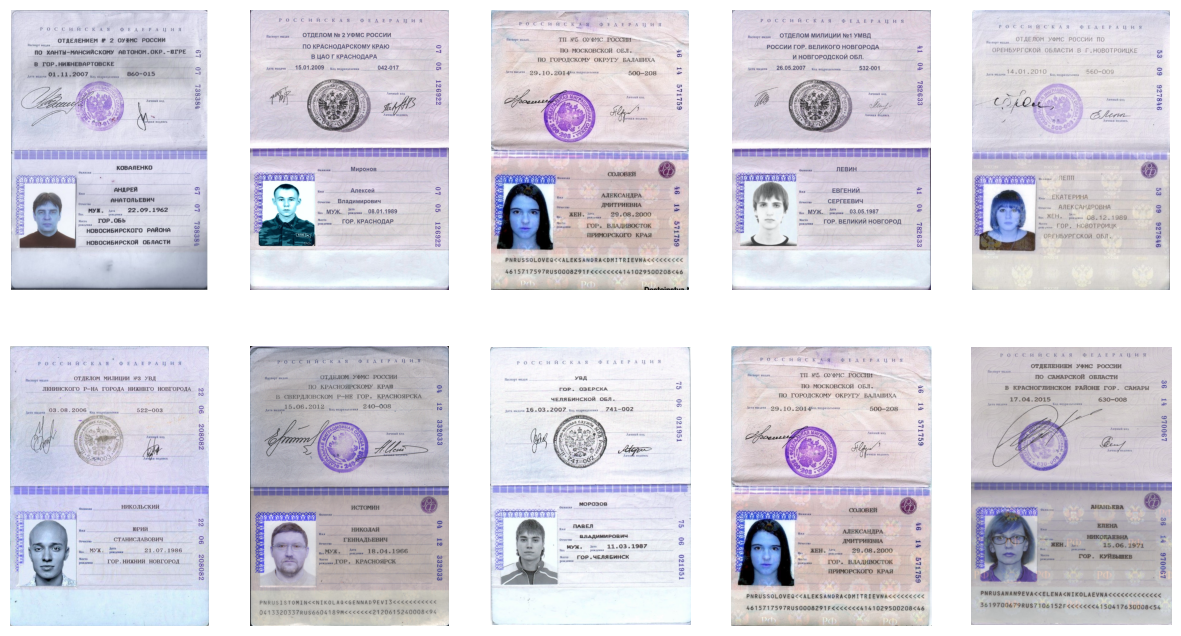

In [ ]:
# Примеры сканов паспортов

examples_dir = f"{data_dir}/examples"
pas_list = []


for i in os.listdir(examples_dir):
    pas_list.append(f"{examples_dir}/{i}")

print("Всего примеров документа:", len(pas_list), ", 10 первых:")

# Фигура визуализации изображений
fig = plt.figure(figsize=(15,8))
x = 1

# Чтение изображений для фигуры в цикле
for i in pas_list[0:10]:

    img = cv2.imread(i, cv2.COLOR_BGR2GRAY)
    fig.add_subplot(2,5,x)
    plt.imshow(img)
    plt.axis('off')
    x += 1

plt.show()

#### Конфиги

In [ ]:
# Page segmentation modes (PSM):
#  0    Orientation and script detection (OSD) only.
#  1    Automatic page segmentation with OSD.
#  2    Automatic page segmentation, but no OSD, or OCR. (not implemented)
#  3    Fully automatic page segmentation, but no OSD. (Default)
#  4    Assume a single column of text of variable sizes.
#  5    Assume a single uniform block of vertically aligned text.
#  6    Assume a single uniform block of text.
#  7    Treat the image as a single text line.
#  8    Treat the image as a single word.
#  9    Treat the image as a single word in a circle.
# 10    Treat the image as a single character.
# 11    Sparse text. Find as much text as possible in no particular order.
# 12    Sparse text with OSD.
# 13    Raw line. Treat the image as a single text line,
#       bypassing hacks that are Tesseract-specific.

# Параметры режимов Tesseract
tesseract_conf = {
    "0": r"--oem 3 --psm 0",
    "1": r"--oem 3 --psm 1",
    "2": r"--oem 3 --psm 2",
    "3": r"--oem 3 --psm 3",
    "4": r"--oem 3 --psm 4",
    "5": r"--oem 3 --psm 5",
    "6": r"--oem 3 --psm 6",
    "7": r"--oem 3 --psm 7",
    "8": r"--oem 3 --psm 8",
    "9": r"--oem 3 --psm 9",
    "10": r"--oem 3 --psm 10",
    "11": r"--oem 3 --psm 11",
    "12": r"--oem 3 --psm 12",
    "13": r"--oem 3 --psm 13",
}

## Общие функции

In [ ]:
# Базовые функции преобразования
def image_resizing(img):
    return cv2.resize(img, (X, Y), interpolation = cv2.INTER_AREA)


def show_2_images(img_1, img_2):
    # Фигура визуализации изображений
    fig = plt.figure(figsize=(15,8))
    fig.add_subplot(1,2,1)
    plt.imshow(image_)
    fig.add_subplot(1,2,2)
    plt.imshow(text_detected)
    plt.show()


def perspective_transformation(img, top, down, right, left):

    # Обрезка контуров по входящим границам текста
    src_points = np.float32([[0, 0], [X, 0], [0, Y], [X, Y]])
    dst_points = np.float32(
        [
            [0-left+P, 0-top+P],             # Левый вехний угол
            [X+(X-right)-P, 0-top+P],         # Правый вехний угол
            [0-left+P, Y+(Y-down)-P_DWN],     # Левый нижний угол
            [X+(X-right)-P, Y+(Y-down)-P_DWN]  # Правый нижний угол
        ]
    )

    # Матрица преобразования перспективы
    perspective_transform = cv2.getPerspectiveTransform(src_points, dst_points)

    # Преобразование перспективы изображения
    resized_image = image_resizing(img)
    perspective_image = cv2.warpPerspective(resized_image, perspective_transform, (X, Y))

    return perspective_image


def image_rotation(img, angle):

    resized_image = image_resizing(img)
    height, width = resized_image.shape[:2]
    # Определение центра изображения
    center = (width/2, height/2)

    # Создание матрицы поворота
    rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=angle, scale=1)

    resized_image = image_resizing(img)

    # Применение матрицы поворота
    rotated_image = cv2.warpAffine(src=resized_image, M=rotate_matrix, dsize=(width, height))

    return rotated_image

In [ ]:
# Вспомогательные утилиты
def is_new_pass(resized_img):

    y1 = 1350
    y2 = 1420
    x1 = 510
    x2 = 1000

    rf_label = img[y1:y2, x1:x2]

    plt.imshow(rf_label)
    plt.show()

    # return cv2.rectangle(
    #     resized_img,
    #     (x1, y1),
    #     (x2, y2),
    #     COLOR,
    #     2
    # )


def calculate_pixel_density(image):
    # Преобразуем изображение в оттенки серого

    # Подсчитываем количество пикселей на изображении
    total_pixels = image.shape[0] * image.shape[1]

    # Вычисляем плотность пикселей
    pixel_density = total_pixels / 255

    return pixel_density


def timeit(func):
    """
    Подсчитывает время выполнения обернутой функции.
    """

    def wrapper(*args, **kwargs):
        start = datetime.now()
        result = func(*args, **kwargs)
        elapsed_time = datetime.now() - start
        print(elapsed_time)
        return result

    return wrapper

In [ ]:
# Бинаризация и подготовка
def find_most_common_color(img):

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Подсчет количества пикселей для каждого цвета
    pixels = img_rgb.reshape(-1, 3)
    counts = np.bincount(pixels[:, 0]*65536 + pixels[:, 1]*256 + pixels[:, 2])

    # Найти наиболее частый цвет
    rgb_value = np.argmax(counts)
    b = rgb_value // 65536
    g = (rgb_value % 65536) // 256
    r = (rgb_value % 65536) % 256

    return np.array([r, g, b])


def replace_background(gray_img, lt):
    # Определение цвета, который нужно заменить (в данном случае RGB красного цвета)
    lower_threshold  = np.array([lt, lt, lt], dtype="uint8") # 90
    upper_threshold  = np.array([255, 255, 255], dtype="uint8")

    # Замена цвета на белый
    mask = cv2.inRange(gray_img, lower_threshold , upper_threshold)
    gray_img[mask > 0] = (255, 255, 255)
    return gray_img


def remove_background(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Пороговая обработка для создания маски
    _, mask = cv2.threshold(gray_img, 170, 255, cv2.THRESH_BINARY)
    # Инвертирование маски
    mask = cv2.bitwise_not(mask)
    # Применение маски к изображению
    result = cv2.bitwise_and(img, img, mask=mask)
    # Замена фона белым цветом
    result[mask == 0] = [255, 255, 255]

    return result


def standard_image_binarization(img):
    """Стандартная бинаризация для улучшения читаемости
    текста методами OCR.
    """
    blur = cv2.GaussianBlur(img, (1, 3), 0)
    kernel = np.ones((3, 1), np.uint8)

    opn = cv2.morphologyEx(blur, cv2.MORPH_OPEN, kernel)
    close = cv2.morphologyEx(opn, cv2.MORPH_CLOSE, kernel)

    result_image = cv2.GaussianBlur(close, (1, 1), 0)

    return result_image


def adaptive_binarization(
        img,
        blur: tuple[int, int],
        max_value: int,
        block_size: int,
        c: float
        ) -> np.array:

    # Применение гауссовского размытия для снижения шумов
    blurred = cv2.GaussianBlur(img, blur, 0)

    # Применение адаптивной бинаризации
    binary_image = cv2.adaptiveThreshold(
        blurred,
        max_value,                       # max_value <= 255
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # adaptive_method
        cv2.THRESH_BINARY_INV,           # threshold_type
        block_size,                      # block_size. 3, 5, 7, and so on.
        c                                # constant subtracted from the mean or weighted mean
    )

    return binary_image


def enhance_text(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Применение порогового оператора для выделения текста
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Применение дилатации для увеличения контраста текста
    kernel = np.ones((1,1), np.uint8)
    dilated = cv2.dilate(binary, kernel, iterations=1)

    return dilated


def canny_edges(image):
    edges = cv2.Canny(image, 300, 300)
    return edges



def denoising(image):
    image = image.copy()
    denoised_img = cv2.medianBlur(image, 5)

    # Применяем билатеральный фильтр для удаления дефектов и сохранения краев
    denoised_img = cv2.bilateralFilter(denoised_img, 9, 75, 75)

    return denoised_img


def apply_binarization(gray_image, method):

    if method == "standard":
        result = standard_image_binarization(gray_image.copy())

    elif method == "enhance":
        result = enhance_text(gray_image.copy())

    elif method == "canny":
        result = canny_edges(gray_image.copy())

    elif method == "adaptive":
        blur = (5, 5)
        result = adaptive_binarization(
            cv2.cvtColor(gray_image.copy(), cv2.COLOR_BGR2GRAY),
            blur,
            255,                                         # 255
            21,                                          # 21
            5                                            # 5
        )

    else:
        result = gray_image

    return result

In [ ]:
def image_labeling(img):
    """Нарезка изображения на участки с текстом"""

    if FIT:
        rectangle_points = rectangle_points_fitted
    else:
        rectangle_points = rectangle_points_unfitted

    produced = img[
        rectangle_points["produced_y1"]:rectangle_points["produced_y2"],
        rectangle_points["produced_x1"]:rectangle_points["produced_x2"],
    ]  # Кем выдан, item 0

    produced_date = img[
        rectangle_points["produced_date_y1"]:rectangle_points["produced_date_y2"],
        rectangle_points["produced_date_x1"]:rectangle_points["produced_date_x2"],
    ]  # Когда выдан, item 1

    produced_code = img[
        rectangle_points["produced_code_y1"]:rectangle_points["produced_code_y2"],
        rectangle_points["produced_code_x1"]:rectangle_points["produced_code_x2"],
    ]  # Код подразделения, item 2

    last_name = img[
        rectangle_points["last_name_y1"]:rectangle_points["last_name_y2"],
        rectangle_points["last_name_x1"]:rectangle_points["last_name_x2"],
    ]  # Фамилия, item 3

    name = img[
        rectangle_points["name_y1"]:rectangle_points["name_y2"],
        rectangle_points["name_x1"]:rectangle_points["name_x2"],
    ]  # Имя, item 4

    middle_name = img[
        rectangle_points["middle_name_y1"]:rectangle_points["middle_name_y2"],
        rectangle_points["middle_name_x1"]:rectangle_points["middle_name_x2"],
    ]  # Отчетство, item 5

    gender = img[
        rectangle_points["gender_y1"]:rectangle_points["gender_y2"],
        rectangle_points["gender_x1"]:rectangle_points["gender_x2"],
    ]  # Пол, item 6

    birthdate = img[
        rectangle_points["birthdate_y1"]:rectangle_points["birthdate_y2"],
        rectangle_points["birthdate_x1"]:rectangle_points["birthdate_x2"],
    ]  # Дата рождения, item 7

    city = img[
        rectangle_points["city_y1"]:rectangle_points["city_y2"],
        rectangle_points["city_x1"]:rectangle_points["city_x2"],
    ]  # Город, item 8

    series = img[
        rectangle_points["series_y1"]:rectangle_points["series_y2"],
        rectangle_points["series_x1"]:rectangle_points["series_x2"],
    ]  # Серия, item 9
    series = cv2.rotate(series, cv2.ROTATE_90_COUNTERCLOCKWISE)

    number = img[
        rectangle_points["number_y1"]:rectangle_points["number_y2"],
        rectangle_points["number_x1"]:rectangle_points["number_x2"],
    ]  # Номер, item 10
    number = cv2.rotate(number, cv2.ROTATE_90_COUNTERCLOCKWISE)

    return (
        produced, produced_date, produced_code,
        last_name, name, middle_name, gender,
        birthdate, city, series, number
    )

In [ ]:
def get_contours(bboxes_from_detector):
    """
    Возвращает границы текста на изображении.
    """
    _top = 1200
    _dwn = 600
    _lft = 800
    _rgh = 600

    for con in bboxes_from_detector[0][0]:

        if con[0] > 0 and con[0] < _lft:
            _lft = con[0]
        if con[1] > _rgh:
            _rgh = con[1]
        if con[2] < _top:
            _top = con[2]
        if con[3] < 1100 and con[3] > _dwn:
            _dwn = con[3]

    return _top, _dwn, _rgh, _lft

In [ ]:
def image_preparation(img, angle, top, down, right, left, silent=True):

    # pixel_density = calculate_pixel_density(img)
    # Применение стандартного размера изображения и оттенков серого
    image_resized = image_resizing(img)

    # Удалим фон левой части скана и преобразуем в оттенки серого
    image_without_background = remove_background(image_resized)

    # gray_image = cv2.cvtColor(image_without_background, cv2.COLOR_BGR2GRAY)

    # Применим стандартную бинаризацию к левой части изображения
    image_binary = apply_binarization(image_without_background, None)
    # image_binary = denoising(image_binary)

    # Трансформации поворота
    rotated_image = image_rotation(image_resized, angle)
    # -- перспективы
    if FIT:
        image_transformed = perspective_transformation(rotated_image.copy(), top, down, right, left)
        rectangle_points = rectangle_points_fitted
    else:
        image_transformed = rotated_image.copy()
        rectangle_points = rectangle_points_unfitted

    # Контуры лейблов
    image_transformed_ = cv2.rectangle(
        image_transformed,
        (rectangle_points["produced_x1"], rectangle_points["produced_y1"]),   # Левый верхний угол
        (rectangle_points["produced_x2"], rectangle_points["produced_y2"]),   # Правый нижний угол
        COLOR,                                                                #  Цвет RGB
        2                                                                     # Толщина линии
    )

    image_transformed_ = cv2.rectangle(
        image_transformed,
        (rectangle_points["produced_date_x1"], rectangle_points["produced_date_y1"]),
        (rectangle_points["produced_date_x2"], rectangle_points["produced_date_y2"]),
        COLOR,
        2
    )

    image_transformed_ = cv2.rectangle(
        image_transformed,
        (rectangle_points["produced_code_x1"], rectangle_points["produced_code_y1"]),
        (rectangle_points["produced_code_x2"], rectangle_points["produced_code_y2"]),
        COLOR,
        2
    )

    image_transformed_ = cv2.rectangle(
        image_transformed,
        (rectangle_points["last_name_x1"], rectangle_points["last_name_y1"]),
        (rectangle_points["last_name_x2"], rectangle_points["last_name_y2"]),
        COLOR,
        2
    )

    image_transformed_ = cv2.rectangle(
        image_transformed,
        (rectangle_points["name_x1"], rectangle_points["name_y1"]),
        (rectangle_points["name_x2"], rectangle_points["name_y2"]),
        COLOR,
        2
    )

    image_transformed_ = cv2.rectangle(
        image_transformed,
        (rectangle_points["middle_name_x1"], rectangle_points["middle_name_y1"]),
        (rectangle_points["middle_name_x2"], rectangle_points["middle_name_y2"]),
        COLOR,
        2
    )

    image_transformed_ = cv2.rectangle(
        image_transformed,
        (rectangle_points["gender_x1"], rectangle_points["gender_y1"]),
        (rectangle_points["gender_x2"], rectangle_points["gender_y2"]),
        COLOR,
        2
    )

    image_transformed_ = cv2.rectangle(
        image_transformed,
        (rectangle_points["birthdate_x1"], rectangle_points["birthdate_y1"]),
        (rectangle_points["birthdate_x2"], rectangle_points["birthdate_y2"]),
        COLOR,
        2
    )

    image_transformed_ = cv2.rectangle(
        image_transformed,
        (rectangle_points["city_x1"], rectangle_points["city_y1"]),
        (rectangle_points["city_x2"], rectangle_points["city_y2"]),
        COLOR,
        2
    )

    image_transformed_ = cv2.rectangle(
        image_transformed,
        (rectangle_points["series_x1"], rectangle_points["series_y1"]),
        (rectangle_points["series_x2"], rectangle_points["series_y2"]),
        COLOR,
        2
    )

    image_transformed_ = cv2.rectangle(
        image_transformed,
        (rectangle_points["number_x1"], rectangle_points["number_y1"]),
        (rectangle_points["number_x2"], rectangle_points["number_y2"]),
        COLOR,
        2
    )

    # Фигура визуализации изображений
    if silent == False:
        fig = plt.figure(figsize=(15,8))
        fig.add_subplot(1,2,1)
        plt.imshow(image_resized)
        fig.add_subplot(1,2,2)
        plt.imshow(image_transformed_)
        plt.show()

    return image_transformed

In [ ]:
 # Функции распознавания изображений tesseract и easyocr
def teseract_recognition(img, conf=r"--oem 3 --psm 6"):
    return pytesseract.image_to_string(img, lang="rus", config=conf)


def easyocr_recognition(img):
    return easyocr.Reader(["ru"], gpu=True).readtext(
        img, detail=0, paragraph=False, text_threshold=0.7
    )

In [ ]:
# Тракты
def text_extractor(prepared_img, engine):

    pas_labels = image_labeling(prepared_img)

    result_list = []
    result_json = {}

    if engine == "tess":
        white_list_id = 0
        for lbl in pas_labels:
            extracted_text = teseract_recognition(lbl, conf=white_lists[str(white_list_id)])
            extracted_text = re.sub(r'[\n\x0c`_]', " ", extracted_text)
            result_list.append(extracted_text)
            white_list_id += 1
    elif engine == "easy":
        for lbl in pas_labels:
            extracted_text = easyocr_recognition(lbl)
            extracted_text = ''.join(str(f"{elem} ") for elem in list(extracted_text))
            result_list.append(extracted_text)
    elif engine == "combo":
        for lbl in pas_labels:
            print(lbl)
            extracted_text = "NoOcrEngine"
            result_list.append(extracted_text)
    else:
        for lbl in pas_labels:
            extracted_text = "NoOcrEngine"
            result_list.append(extracted_text)

    i = 0

    for k in [
        "Кем выдан", "Когда выдан", "Код подразделения",
        "Фамилия", "Имя", "Отчество", "Пол", "Дата рождения",
        "Город", "Серия", "Номер"
    ]:
        result_json[k] = result_list[i]
        i += 1

    return result_json


def main_extractor(image_resized):
    """Извлекает влоб по заданным координатам из
    размеченных craft блоков текста."""
    producer_name = get_producer_name(image_resized)
    producer_date = get_producer_date(image_resized)
    producer_code = get_producer_code(image_resized)
    last_name = get_last_name(image_resized)
    name = get_name(image_resized)
    middle_name = get_name(image_resized)
    gender = get_gender(image_resized)
    birthdate = get_birthdate(image_resized)
    city = get_city(image_resized)
    series = get_series(image_resized)
    number = get_number(image_resized)

    result_json = {
        "Кем выдан": producer_name,
        "Когда выдан": producer_date,
        "Код подразделения": producer_code,
        "Фамилия": last_name,
        "Имя": name,
        "Отчество": middle_name,
        "Пол": gender,
        "Дата рождения": birthdate,
        "Город": city,
        "Серия": series,
        "Номер": number,
    }

    return result_json

In [ ]:
# Функции извлечения оснвных атрибутов
def get_producer_name(image_resized):
    # image_resized = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    producer_name = ""

    for h in bboxx_h[0][0]:
        if (
            h[0] < 780 \
            and h[3] < 300
        ):
            box = image_resized[h[2]:h[3], h[0]:h[1]]
            extracted_text = teseract_recognition(
                box,
                "--oem 3 --psm 6 -c tessedit_char_whitelist=№0123456789АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ.-абвгдеёжзийклмнопрстуфхцчшщъыьэюя' '"
            )
            producer_name = producer_name + extracted_text
            producer_name = re.sub(r'[\n\x0c`_]', " ", producer_name)
    return producer_name


def get_producer_date(image_resized):
    # image_resized = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    producer_date = ""

    for h in bboxx_h[0][0]:
        if (
            h[2] > 250 \
            and h[3] < 350 \
            and h[1] < 600
        ):
            box = image_resized[h[2]:h[3], h[0]:h[1]]
            extracted_text = teseract_recognition(
                box,
                "--oem 3 --psm 6 -c tessedit_char_whitelist=0123456789."
            )
            producer_date = producer_date + extracted_text
            producer_date = re.sub(r'[\n\x0c`_,]', " ", producer_date)
    return producer_date


def get_producer_code(image_resized):
    # image_resized = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    producer_code = ""

    for h in bboxx_h[0][0]:
        if (
            h[2] > 250 \
            and h[3] < 350 \
            and h[0] < 500
        ):
            box = image_resized[h[2]:h[3], h[0]:h[1]]
            extracted_text = teseract_recognition(
                box,
                "--oem 3 --psm 6 -c tessedit_char_whitelist=0123456789-"
            )
            producer_code = producer_code + extracted_text
            producer_code = re.sub(r'[\n\x0c`_,]', " ", producer_code)
    return producer_code


def get_last_name(image_resized):
    # image_resized = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    last_name = ""

    for h in bboxx_h[0][0]:
        if (
            h[3] > 600 \
            and h[3] < 750
        ):
            box = image_resized[h[2]:h[3], h[0]:h[1]]
            extracted_text = teseract_recognition(
                box,
                "--oem 3 --psm 6 -c tessedit_char_whitelist=АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюя' '"
            )
            last_name = last_name + extracted_text
            last_name = re.sub(r'[\n\x0c`_,]', " ", last_name)
    return last_name


def get_name(image_resized):
    # image_resized = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    name = ""

    for h in bboxx_h[0][0]:
        if (
            h[3] > 700 \
            and h[3] < 900
        ):
            box = image_resized[h[2]:h[3], h[0]:h[1]]
            extracted_text = teseract_recognition(
                box,
                "--oem 3 --psm 6 -c tessedit_char_whitelist=АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюя' '"
            )
            name = name + extracted_text
            name = re.sub(r'[\n\x0c`_,]', " ", name)
    return name


def get_gender(image_resized):
    # image_resized = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    gender = ""

    for h in bboxx_h[0][0]:
        if (
            h[3] > 800 \
            and h[3] < 950 \
            and h[1] < 450
        ):
            box = image_resized[h[2]:h[3], h[0]:h[1]]
            extracted_text = teseract_recognition(
                box,
                "--oem 3 --psm 6 -c tessedit_char_whitelist=МУЖЕН."
            )
            gender = gender + extracted_text
            gender = re.sub(r'[\n\x0c`_,]', " ", gender)
    return gender


def get_birthdate(image_resized):
    # image_resized = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    birthdate = ""

    for h in bboxx_h[0][0]:
        if (
            h[3] > 800 \
            and h[3] < 950 \
            and h[0] > 450
        ):
            box = image_resized[h[2]:h[3], h[0]:h[1]]
            extracted_text = teseract_recognition(
                box,
                "--oem 3 --psm 6 -c tessedit_char_whitelist=0123456789."
            )
            birthdate = birthdate + extracted_text
            birthdate = re.sub(r'[\n\x0c`_,]', " ", birthdate)
    return birthdate


def get_city(image_resized):
    # image_resized = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    city = ""

    for h in bboxx_h[0][0]:
        if (
            h[2] > 880 \
            and h[2] < 1000
        ):
            box = image_resized[h[2]:h[3], h[0]:h[1]]
            extracted_text = teseract_recognition(
                box,
                "--oem 3 --psm 6 -c tessedit_char_whitelist=№0123456789АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ.-абвгдеёжзийклмнопрстуфхцчшщъыьэюя' '"
            )
            city = city + extracted_text
            city = re.sub(r'[\n\x0c`_]', " ", city)
    return city


def get_series(image_resized):
    series = image_resized[
        rectangle_points["series_y1"]:rectangle_points["series_y2"],
        rectangle_points["series_x1"]:rectangle_points["series_x2"],
    ]  # Серия, item 9
    series = cv2.rotate(series, cv2.ROTATE_90_COUNTERCLOCKWISE)
    extracted_text = teseract_recognition(
        series,
        "--oem 3 --psm 6 -c tessedit_char_whitelist=0123456789' '"
    )

    return extracted_text


def get_number(image_resized):
    number = image_resized[
        rectangle_points["number_y1"]:rectangle_points["number_y2"],
        rectangle_points["number_x1"]:rectangle_points["number_x2"],
    ]  # Номер, item 10
    number = cv2.rotate(number, cv2.ROTATE_90_COUNTERCLOCKWISE)
    extracted_text = teseract_recognition(
        number,
        "--oem 3 --psm 6 -c tessedit_char_whitelist=0123456789"
    )

    return extracted_text

In [ ]:
# Детектирование боксов текста на изображении
def get_bboxes(image_resized):
    """Принимает на вход изображение и возвращает объект EasyOcr с координатами
    текстовых блоков.
    Ссылка на доку: https://jaided.ai/easyocr/documentation/
    """
    bboxes = easyocr.Reader(["ru"], gpu=True).detect(
        image_resized,
        min_size = 50,            # 10   Filter text box smaller than minimum value in pixel
        text_threshold = 0.7,     # 0.7  Text confidence threshold
        low_text = 0.3,           # 0.4  Text low-bound score
        link_threshold = 0.4,     # 0.4  Link confidence threshold
        canvas_size = 2560,       # 2560 Maximum image size. Image bigger than this value will be resized down
        mag_ratio = 1,            # 1    Image magnification ratio
        slope_ths = 0.1,          # 0.1  Maximum slope (delta y/delta x) to considered merging. Low value means tiled boxes will not be merged
        ycenter_ths = 0.5,        # 0.5  Maximum shift in y direction. Boxes with different level should not be merged
        height_ths = 0.5,         # 0.5  Maximum different in box height. Boxes with very different text size should not be merged
        width_ths = 1.1,          # 0.5  Maximum horizontal distance to merge boxes
        add_margin = 0.1,         # 0.1  Extend bounding boxes in all direction by certain value. This is important for language with complex script
        optimal_num_chars = None  # If specified (int), bounding boxes with estimated number of characters near this value are returned first
    )

    return bboxes

## Детектирование блоков

In [ ]:
# Белые листы tesseract по блокам

white_lists = {
    "0": r"--oem 3 --psm 6 -c tessedit_char_whitelist=№0123456789АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ.-абвгдеёжзийклмнопрстуфхцчшщъыьэюя' '",
    "1": r"--oem 3 --psm 6 -c tessedit_char_whitelist=0123456789.",
    "2": r"--oem 3 --psm 6 -c tessedit_char_whitelist=0123456789-",
    "3": r"--oem 3 --psm 6 -c tessedit_char_whitelist=АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюя' '",
    "4": r"--oem 3 --psm 6 -c tessedit_char_whitelist=АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюя' '",
    "5": r"--oem 3 --psm 6 -c tessedit_char_whitelist=АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюя' '",
    "6": r"--oem 3 --psm 6 -c tessedit_char_whitelist=МУЖЕН.",
    "7": r"--oem 3 --psm 6 -c tessedit_char_whitelist=0123456789.",
    "8": r"--oem 3 --psm 6 -c tessedit_char_whitelist=№0123456789АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ.-абвгдеёжзийклмнопрстуфхцчшщъыьэюя' '",
    "9": r"--oem 3 --psm 6 -c tessedit_char_whitelist=0123456789' '",
    "10": r"--oem 3 --psm 6 -c tessedit_char_whitelist=0123456789",
}

In [ ]:
# Блоки жесткой разметки участков документа фиксированного размера
rectangle_points_unfitted = {
    "produced_y1": 70,
    "produced_y2": 230,
    "produced_x1": 10,
    "produced_x2": 780,

    "produced_date_y1": 220,
    "produced_date_y2": 300,
    "produced_date_x1": 100,
    "produced_date_x2": 350,

    "produced_code_y1": 220,
    "produced_code_y2": 300,
    "produced_code_x1": 450,
    "produced_code_x2": 780,

    "last_name_y1": 630,
    "last_name_y2": 750,
    "last_name_x1": 290,
    "last_name_x2": 780,

    "name_y1": 750,
    "name_y2": 810,
    "name_x1": 290,
    "name_x2": 780,

    "middle_name_y1": 800,
    "middle_name_y2": 850,
    "middle_name_x1": 290,
    "middle_name_x2": 780,

    "gender_y1": 850,
    "gender_y2": 900,
    "gender_x1": 290,
    "gender_x2": 400,

    "birthdate_y1": 850,
    "birthdate_y2": 900,
    "birthdate_x1": 460,
    "birthdate_x2": 780,

    "city_y1": 880,
    "city_y2": 1150,
    "city_x1": 330,
    "city_x2": 780,

    "series_y1": 70,
    "series_y2": 300,
    "series_x1": 790,
    "series_x2": 840,

    "number_y1": 300,
    "number_y2": 500,
    "number_x1": 790,
    "number_x2": 840,
}

# Если картинка подгоняется по краям текста, то используем эти координаты
rectangle_points_fitted = {
    "produced_y1": 80,
    "produced_y2": 250,
    "produced_x1": 10,
    "produced_x2": 780,

    "produced_date_y1": 230,
    "produced_date_y2": 310,
    "produced_date_x1": 100,
    "produced_date_x2": 350,

    "produced_code_y1": 230,
    "produced_code_y2": 310,
    "produced_code_x1": 450,
    "produced_code_x2": 780,

    "last_name_y1": 700,
    "last_name_y2": 820,
    "last_name_x1": 290,
    "last_name_x2": 780,

    "name_y1": 820,
    "name_y2": 870,
    "name_x1": 290,
    "name_x2": 780,

    "middle_name_y1": 870,
    "middle_name_y2": 920,
    "middle_name_x1": 290,
    "middle_name_x2": 780,

    "gender_y1": 920,
    "gender_y2": 970,
    "gender_x1": 290,
    "gender_x2": 400,

    "birthdate_y1": 920,
    "birthdate_y2": 970,
    "birthdate_x1": 460,
    "birthdate_x2": 780,

    "city_y1": 970,
    "city_y2": 1150,
    "city_x1": 330,
    "city_x2": 780,

    "series_y1": 70,
    "series_y2": 300,
    "series_x1": 790,
    "series_x2": 840,

    "number_y1": 300,
    "number_y2": 500,
    "number_x1": 790,
    "number_x2": 840,
}

In [ ]:
# ГЛОБАЛЬНЫЕ ПЕРЕМЕННЫЕ!

PIC_ID = 2
X = 850
Y = 1200
P = 10
P_DWN = 50
COLOR = (100, 0, 0)
FIT = False

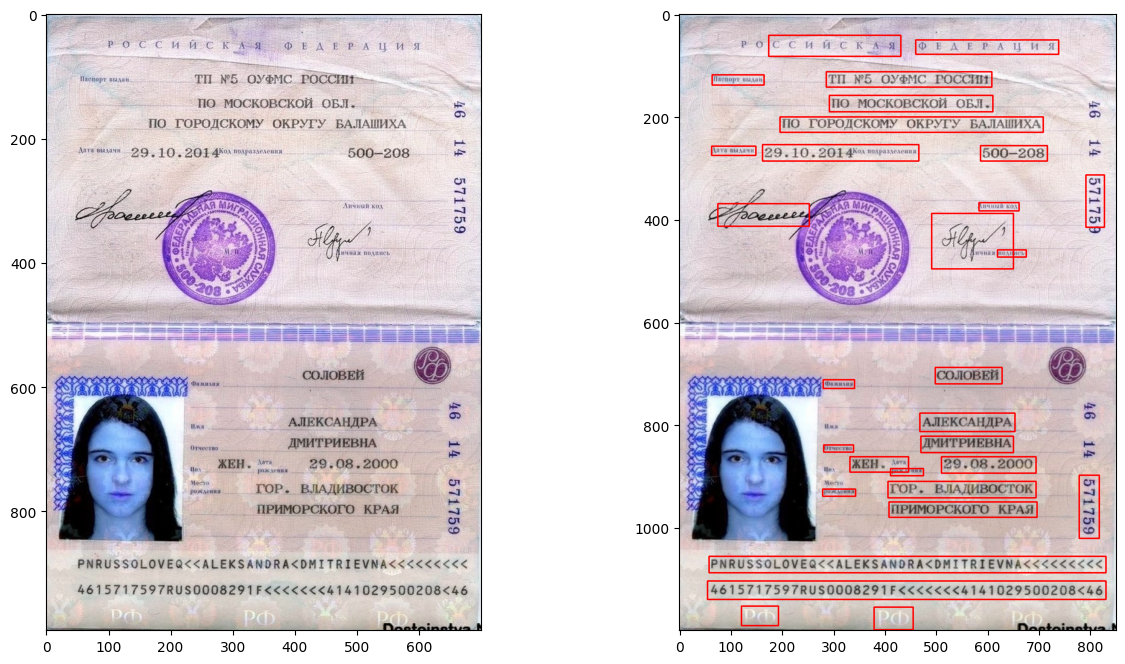

Верхнаяя граница: 41 
Нижняя граница: 1088 
Левая граница: 55 
Правая граница: 830


In [ ]:
image_ = cv2.imread(pas_list[PIC_ID])
image_resized = image_resizing(image_)

bboxx_h = get_bboxes(image_resized)

_top, _dwn, _rgh, _lft = get_contours(bboxx_h)

for h in bboxx_h[0][0]:

    text_detected = cv2.rectangle(
        image_resized, (h[0], h[2]), (h[1], h[3]),(255, 0, 0), 2
    )

# Фигура визуализации изображений
show_2_images(image_, text_detected)
print(
    "Верхнаяя граница:", _top, "\n"
    "Нижняя граница:", _dwn, "\n"
    "Левая граница:", _lft, "\n"
    "Правая граница:", _rgh
)

## Извлечение атрибутов из блоков

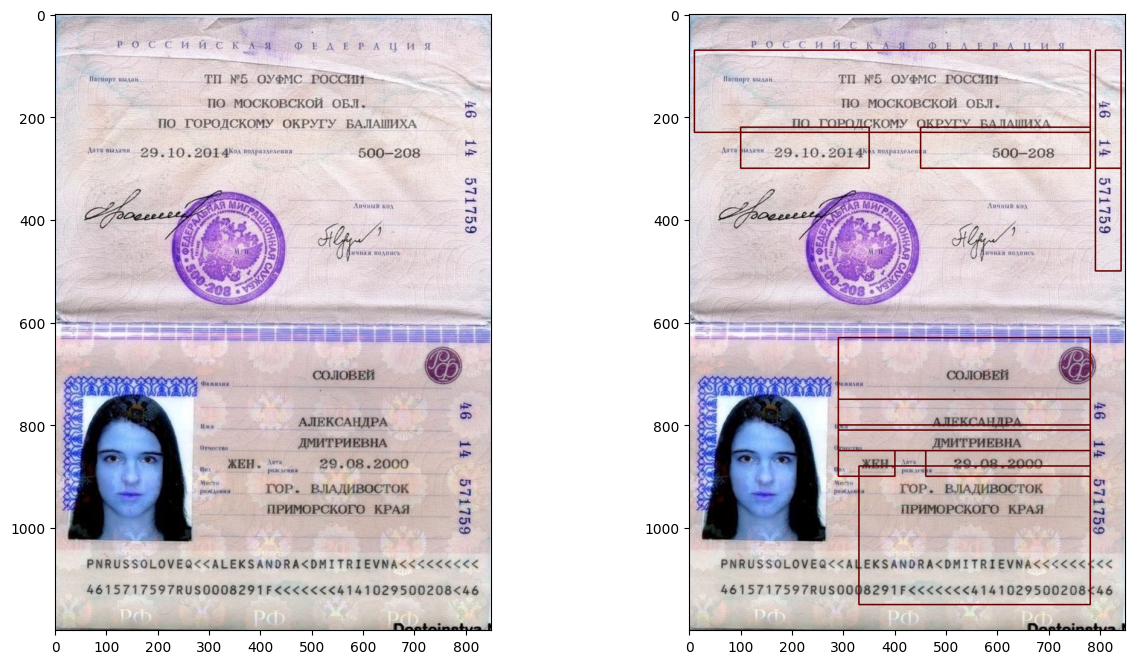

In [ ]:
image_ = cv2.imread(pas_list[PIC_ID])
image_resized = image_resizing(image_)

# Детектирование блоков текста
bboxx_h = easyocr.Reader(["ru"], gpu=True).detect(image_resized)

top, down, right, left = get_contours(bboxx_h)

image_prepared_ = image_preparation(image_, 0, top, down, right, left, silent=False)

In [ ]:
%%time
text_extractor(image_prepared_, engine="tess")

CPU times: user 57.9 ms, sys: 9.5 ms, total: 67.4 ms
Wall time: 2.18 s


{'Кем выдан': 'Повоорт стало ОТДЕЛОМ № 2 УЭМС РОССИИ ПО КРАСНОДАРСКОМУ КРАЮ ЦАО Г КРАСНОДАРА ',
 'Когда выдан': '15.01.2009 ',
 'Код подразделения': '042-017 ',
 'Фамилия': 'орда Миооноа ',
 'Имя': 'о  АЛВКОЕЙ НИ ',
 'Отчество': 'ини ких  ВЛЯДИМИООВИЧ ',
 'Пол': '.МУ. ',
 'Дата рождения': '..08.01.1989 ',
 'Город': 'и ГОР. КРАСНОДАР ',
 'Серия': '',
 'Номер': '126929 '}

In [ ]:
pic_n = 0
for l in pas_list:

    if "gif" not in l:
        image_ = cv2.imread(l)
        image_resized = image_resizing(image_)
        bboxx_h = easyocr.Reader(["ru"], gpu=True).detect(image_resized)
        for h in bboxx_h[0][0]:
            box = image_resized[h[2]:h[3], h[0]:h[1]]
            try:
                cv2.imwrite(f'{data_target}/{pic_n}.png', box)
            except Exception:
                pass
            pic_n += 1

In [ ]:
producer_name = ""

for h in bboxx_h[0][0]:
    if (
        h[0] < 780 \
        and h[2] < 300
    ):
        box = image_prepared_[h[2]:h[3], h[0]:h[1]]
        extracted_text = teseract_recognition(box)
        producer_name = producer_name + extracted_text
        producer_name = re.sub(r'[\n\x0c`_]', " ", producer_name)
print(producer_name)
print(re.findall(r"\b(\d{2}).(\d{2}).(\d{4})\b", producer_name))
print(re.findall(r"...-...", producer_name))

СС И-Й5е К ФЕ АЕ РА ия Паспорт вылан ТИ СУФМС РОССИИ по МОСКОВСКОЙ ОБЛ. ПО ГОРОДСКОМУ ОКРУРУ БАЛАШИХА Айта малачи 29.10.2001 кА подразлеленйя 500-208 
[('29', '10', '2001')]
['С И-Й5е', '500-208']


In [ ]:
%%time
main_extractor(image_prepared_)

CPU times: user 128 ms, sys: 20.4 ms, total: 149 ms
Wall time: 2.85 s


{'Кем выдан': 'п. т ТВ. ые Е Рес т выдан ДЕЛОМ № 2 УФМС РОССИИ  КРАСНОДАРСКОМУ КРАЮ АО ГКРАСНОДЛАРА приья тг. о Брио 6 58 ',
 'Когда выдан': '',
 'Код подразделения': '',
 'Фамилия': 'Е ЕЕ ЕЕЕ Е еее еее ',
 'Имя': 'оне Алек с ',
 'Отчество': 'оне Алек с ',
 'Пол': 'У ',
 'Дата рождения': '',
 'Город': '- адимирович ть с с н ',
 'Серия': '07 05\n',
 'Номер': '126922\n'}

In [ ]:
%%time
text_extractor(image_prepared_, engine="easy")

CPU times: user 28 s, sys: 3.36 s, total: 31.3 s
Wall time: 31.4 s


{'Кем выдан': 'Шаспорт выдам ОТДЕЛОМ &: 2 УФМС РОССИИ ПО КРАСНОДАРСКОМУ КРАЮ В ЦАО Г КРАСНОДАРА ',
 'Когда выдан': '75.01.2009 Ко1 ',
 'Код подразделения': '042-017 ',
 'Фамилия': 'Миронов ',
 'Имя': 'Алексей ',
 'Отчество': 'Владимирович ',
 'Пол': 'МУЖ: ',
 'Дата рождения': '08.01.1989 ',
 'Город': 'ГОР. КРАСНОДАР ',
 'Серия': '07 05 ',
 'Номер': '126922 '}

#### Аналитика оперативных результатов

In [ ]:
def comparison(df_reference, df_comparison) -> pd.DataFrame:

    cols = [
        "Кем выдан",
        "Когда выдан", "Код подразделения",
        "Фамилия", "Имя", "Отчетство", "Пол",
        "Дата рождения", "Город", "Серия", "Номер"
    ]

    comparison_list = []
    report_quality = pd.DataFrame(columns=cols)

    for col in cols:
        for i in range(len(df_reference)):
            refer_out = df_reference[col][i]
            comp_out = df_comparison[col][i]
            if str(refer_out) in str(comp_out):
                comparison_list.append(1)
            else:
                comparison_list.append(0)

    comparison_reshape = np.reshape(comparison_list, (len(cols), len(df_reference)))

    report_quality["Кем выдан"] = comparison_reshape[0]
    report_quality["Когда выдан"] = comparison_reshape[1]
    report_quality["Код подразделения"] = comparison_reshape[2]
    report_quality["Фамилия"] = comparison_reshape[3]
    report_quality["Имя"] = comparison_reshape[4]
    report_quality["Отчетство"] = comparison_reshape[5]
    report_quality["Пол"] = comparison_reshape[6]
    report_quality["Дата рождения"] = comparison_reshape[7]
    report_quality["Город"] = comparison_reshape[8]
    report_quality["Серия"] = comparison_reshape[9]
    report_quality["Номер"] = comparison_reshape[10]

    return report_quality

In [ ]:
%%time
def create_report(pas_list) -> pd.DataFrame:

    report = pd.DataFrame(
        columns=[
            "Ссылка", "Движок", "Кем выдан",
            "Когда выдан", "Код подразделения",
            "Фамилия", "Имя", "Отчетство", "Пол",
            "Дата рождения", "Город", "Серия", "Номер"
        ]
    )

    for img_path in pas_list:

        if "gif" not in img_path:

            image_ = cv2.imread(img_path)
            # image_resized = image_resizing(image_)

            bboxx_h = get_bboxes(image_resized)
            # result = main_extractor(image_resized)
            top, down, right, left = get_contours(bboxx_h)
            image_prepared_ = image_preparation(image_, 0, top, down, right, left)
            result = text_extractor(image_prepared_, engine="easy")

            report = report._append({
                "Ссылка": img_path,
                "Движок": "Tesseract",
                "Кем выдан": result["Кем выдан"],
                "Когда выдан": result["Когда выдан"],
                "Код подразделения": result["Код подразделения"],
                "Фамилия": result["Фамилия"],
                "Имя": result["Имя"],
                "Отчетство": result["Отчество"],
                "Пол": result["Пол"],
                "Дата рождения": result["Дата рождения"],
                "Город": result["Город"],
                "Серия": result["Серия"],
                "Номер": result["Номер"]
            }, ignore_index=True)

    return report


df_reference = pd.read_excel(f"{data_dir}/reference.xlsx")
df_comparison = create_report(pas_list)

report_quality = comparison(df_reference, df_comparison)

print(
    f"Среднее качество извлечения на {len(df_reference)} паспортах:",
    pd.Series(report_quality.sum() / len(df_reference) * 100).mean()
)

report_quality.sum() / len(df_reference) * 100

Среднее качество извлечения на 77 паспортах: 0.7083825265643447
CPU times: user 39min 24s, sys: 4min 52s, total: 44min 16s
Wall time: 44min 27s


Кем выдан            0.000000
Когда выдан          0.000000
Код подразделения    1.298701
Фамилия              0.000000
Имя                  0.000000
Отчетство            0.000000
Пол                  0.000000
Дата рождения        1.298701
Город                1.298701
Серия                2.597403
Номер                1.298701
dtype: float64

In [ ]:
%%time
#Создаем отчет распознавания

# for img_path in pas_list:

#     if "gif" not in img_path:

#         image_ = cv2.imread(img_path)
#         image_resized = image_resizing(image_)

#         bboxx_h = easyocr.Reader(["ru"]).detect(image_resized)
#         top, down, right, left = get_contours(bboxx_h)
#         image_prepared_ = image_preparation(image_resized, 0, top, down, right, left, silent=True, fit=False)
#         image_prepared_ = image_preparation(image_, 0, None, None, None, None, silent=True, fit=False)

#         result = text_extractor(image_prepared_, engine="tess")

#         report_tesseract = report_tesseract._append({
#             "Ссылка": img_path,
#             "Движок": "Tesseract",
#             "Кем выдан": result["Кем выдан"],
#             "Когда выдан": result["Когда выдан"],
#             "Код подразделения": result["Код подразделения"],
#             "Фамилия": result["Фамилия"],
#             "Имя": result["Имя"],
#             "Отчетство": result["Отчество"],
#             "Пол": result["Пол"],
#             "Дата рождения": result["Дата рождения"],
#             "Город": result["Город"],
#             "Серия": result["Серия"],
#             "Номер": result["Номер"]
#         }, ignore_index=True)

# report_tesseract.to_excel("tesseract_newbin_output.xlsx")

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs


## Загрузка эталонных значений и вывода OCR

In [ ]:
data_dir

'/content/drive/My Drive/Data/PasportRF'

In [ ]:
reference = pd.read_excel(f"{data_dir}/reference.xlsx")

easyocr_output = pd.read_excel(f"{data_dir}/output/easyocr_output.xlsx")
tesseract_output = pd.read_excel(f"{data_dir}/output/tesseract_output.xlsx")

tesseract_binary_output = pd.read_excel(f"{data_dir}/output/tesseract_standbin_output.xlsx")
easyocr_binary_output = pd.read_excel(f"{data_dir}/output/easyocr_standbin_output.xlsx")

tesseract_bkgr_output = pd.read_excel(f"{data_dir}/output/tesseract_bkgr_output.xlsx")
easyocr_bkgr_output = pd.read_excel(f"{data_dir}/output/easyocr_bkgr_output.xlsx")

tesseract_white_output = pd.read_excel(f"{data_dir}/output/tesseract_white_output.xlsx")

tesseract_adabin_output = pd.read_excel(f"{data_dir}/output/tesseract_adabin_output.xlsx")

tesseract_hard_output = pd.read_excel(f"{data_dir}/output/tesseract_hard_output.xlsx")

tesseract_newbin_output = pd.read_excel(f"{data_dir}/output/tesseract_newbin_output.xlsx")

## Аналитика итогового отчета

### Tesseract

#### Стандартные настройки

In [ ]:
report_quality = comparison(reference, tesseract_output)

report_quality

,Кем выдан,Когда выдан,Код подразделения,Фамилия,Имя,Отчетство,Пол,Дата рождения,Город,Серия,Номер
0,0,0,1,1,1,1,0,1,1,1,1
1,1,1,1,0,0,0,1,1,1,1,1
2,0,0,0,1,1,1,0,0,0,1,0
3,0,0,0,1,0,1,1,1,0,0,0
4,0,0,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
72,0,0,0,1,0,1,0,0,1,1,1
73,0,0,0,0,0,1,1,0,0,1,1
74,1,1,1,1,0,0,0,0,0,0,1
75,1,1,1,1,1,0,0,0,0,1,1


In [ ]:
report_quality.sum() / len(reference) * 100

Кем выдан            23.376623
Когда выдан          25.974026
Код подразделения    51.948052
Фамилия              63.636364
Имя                  48.051948
Отчетство            53.246753
Пол                  33.766234
Дата рождения        38.961039
Город                36.363636
Серия                61.038961
Номер                87.012987
dtype: float64

In [ ]:
t_ser = pd.Series(report_quality.sum() / len(reference) * 100)
t_ser.mean()

47.57969303423849

#### Жесткая разметка макета

In [ ]:
report_quality = comparison(reference, tesseract_hard_output)

report_quality

,Кем выдан,Когда выдан,Код подразделения,Фамилия,Имя,Отчетство,Пол,Дата рождения,Город,Серия,Номер
0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,1,0,1,1
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
72,0,0,0,0,0,0,0,0,0,0,0
73,0,0,0,0,0,0,0,0,0,0,0
74,0,0,0,0,0,0,0,0,0,0,0
75,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
report_quality.sum() / len(reference) * 100

Кем выдан            1.298701
Когда выдан          0.000000
Код подразделения    1.298701
Фамилия              0.000000
Имя                  1.298701
Отчетство            1.298701
Пол                  2.597403
Дата рождения        1.298701
Город                0.000000
Серия                2.597403
Номер                1.298701
dtype: float64

In [ ]:
t_ser = pd.Series(report_quality.sum() / len(reference) * 100)
t_ser.mean()

1.1806375442739077

#### После новой бинаризации

In [ ]:
report_quality = comparison(reference, tesseract_newbin_output)

report_quality

,Кем выдан,Когда выдан,Код подразделения,Фамилия,Имя,Отчетство,Пол,Дата рождения,Город,Серия,Номер
0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,1,1,0,1,1
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
72,0,0,0,0,0,0,0,0,0,0,0
73,0,0,0,0,0,0,0,0,0,0,0
74,0,0,0,0,0,0,0,0,0,0,0
75,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
report_quality.sum() / len(reference) * 100

Кем выдан             1.298701
Когда выдан           1.298701
Код подразделения     0.000000
Фамилия               0.000000
Имя                   1.298701
Отчетство             1.298701
Пол                  10.389610
Дата рождения         1.298701
Город                 0.000000
Серия                 2.597403
Номер                 1.298701
dtype: float64

In [ ]:
t_ser = pd.Series(report_quality.sum() / len(reference) * 100)
t_ser.mean()

1.889020070838253

#### После стандартной бинаризации

In [ ]:
report_quality = comparison(reference, tesseract_binary_output)

report_quality

,Кем выдан,Когда выдан,Код подразделения,Фамилия,Имя,Отчетство,Пол,Дата рождения,Город,Серия,Номер
0,0,0,1,0,0,1,0,1,0,1,1
1,1,0,1,0,0,0,0,0,1,1,1
2,0,0,1,0,1,0,0,1,0,1,0
3,0,0,0,1,1,1,0,1,0,0,0
4,0,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
72,0,0,0,0,1,0,0,1,0,0,0
73,0,0,0,0,0,0,1,0,0,1,1
74,0,1,0,0,0,0,0,0,0,0,1
75,0,0,1,1,0,0,0,0,0,0,1


In [ ]:
report_quality.sum() / len(reference) * 100

Кем выдан            20.779221
Когда выдан          22.077922
Код подразделения    44.155844
Фамилия              45.454545
Имя                  22.077922
Отчетство            46.753247
Пол                  10.389610
Дата рождения        25.974026
Город                23.376623
Серия                45.454545
Номер                79.220779
dtype: float64

In [ ]:
t_bin_ser = pd.Series(report_quality.sum() / len(reference) * 100)
t_bin_ser.mean()

35.064935064935064

#### После бинаризации с удалением фона

In [ ]:
report_quality = comparison(reference, tesseract_bkgr_output)

report_quality

,Кем выдан,Когда выдан,Код подразделения,Фамилия,Имя,Отчетство,Пол,Дата рождения,Город,Серия,Номер
0,0,0,0,0,0,0,0,0,0,1,1
1,1,1,0,0,0,0,0,0,1,1,1
2,0,0,0,1,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
72,0,0,0,0,0,0,0,0,0,0,0
73,0,0,0,0,0,0,0,0,0,1,1
74,0,0,0,0,0,0,0,0,0,0,1
75,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
report_quality.sum() / len(reference) * 100

Кем выдан             3.896104
Когда выдан           3.896104
Код подразделения     6.493506
Фамилия              23.376623
Имя                   3.896104
Отчетство            16.883117
Пол                   1.298701
Дата рождения         3.896104
Город                 6.493506
Серия                44.155844
Номер                77.922078
dtype: float64

In [ ]:
t_ser = pd.Series(report_quality.sum() / len(reference) * 100)
t_ser.mean()

17.473435655253837

#### Стандартные настройки + белые списки по блокам

In [ ]:
report_quality = comparison(reference, tesseract_white_output)

report_quality

,Кем выдан,Когда выдан,Код подразделения,Фамилия,Имя,Отчетство,Пол,Дата рождения,Город,Серия,Номер
0,0,0,1,0,0,1,0,1,1,1,1
1,1,1,1,0,0,0,0,1,1,1,1
2,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,1,1,1,0,1,0,0,0
4,0,0,1,1,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
72,0,0,0,0,1,0,0,0,1,1,0
73,0,0,0,0,0,0,1,0,0,1,1
74,1,1,0,0,0,0,0,0,0,0,1
75,1,0,1,0,0,0,0,0,0,0,1


In [ ]:
report_quality.sum() / len(reference) * 100

Кем выдан            41.558442
Когда выдан          31.168831
Код подразделения    50.649351
Фамилия              35.064935
Имя                  25.974026
Отчетство            49.350649
Пол                   6.493506
Дата рождения        31.168831
Город                40.259740
Серия                49.350649
Номер                80.519481
dtype: float64

In [ ]:
t_ser = pd.Series(report_quality.sum() / len(reference) * 100)
t_ser.mean()

40.141676505312866

#### С адаптивной бинаризацией

In [ ]:
report_quality = comparison(reference, tesseract_adabin_output)

report_quality

,Кем выдан,Когда выдан,Код подразделения,Фамилия,Имя,Отчетство,Пол,Дата рождения,Город,Серия,Номер
0,0,0,1,1,0,0,0,1,1,1,1
1,1,1,1,0,0,0,1,0,1,1,1
2,0,0,1,1,0,0,0,1,0,1,0
3,0,0,0,1,0,1,1,1,0,0,0
4,0,0,1,1,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
72,0,0,0,0,0,0,0,0,0,1,0
73,0,0,0,0,0,0,0,0,0,1,1
74,0,1,1,0,0,0,0,0,1,0,1
75,1,1,0,1,1,0,0,0,0,0,1


In [ ]:
report_quality.sum() / len(reference) * 100

Кем выдан            18.181818
Когда выдан          25.974026
Код подразделения    41.558442
Фамилия              51.948052
Имя                  27.272727
Отчетство            37.662338
Пол                  29.870130
Дата рождения        29.870130
Город                31.168831
Серия                42.857143
Номер                77.922078
dtype: float64

In [ ]:
t_ser = pd.Series(report_quality.sum() / len(reference) * 100)
t_ser.mean()

37.662337662337656

### EasyOCR

#### Стандартные параметры

In [ ]:
report_quality = comparison(reference, easyocr_output)

report_quality

,Кем выдан,Когда выдан,Код подразделения,Фамилия,Имя,Отчетство,Пол,Дата рождения,Город,Серия,Номер
0,0,0,1,1,1,1,0,0,0,1,1
1,0,0,1,0,0,0,0,1,1,1,1
2,0,0,1,1,1,1,0,0,0,0,1
3,0,0,0,1,1,1,0,1,0,1,1
4,0,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
72,0,0,0,0,1,1,0,0,0,1,0
73,0,0,0,0,1,0,0,0,0,1,1
74,0,1,0,1,0,0,0,0,0,1,1
75,0,0,1,0,1,0,0,0,0,1,1


In [ ]:
report_quality.sum() / len(reference) * 100

Кем выдан             3.896104
Когда выдан          11.688312
Код подразделения    48.051948
Фамилия              74.025974
Имя                  57.142857
Отчетство            49.350649
Пол                   5.194805
Дата рождения        19.480519
Город                 5.194805
Серия                93.506494
Номер                87.012987
dtype: float64

In [ ]:
e_ser = pd.Series(report_quality.sum() / len(reference) * 100)
e_ser.mean()

41.32231404958678

#### После бинаризации

In [ ]:
report_quality = comparison(reference, easyocr_binary_output)

report_quality

,Кем выдан,Когда выдан,Код подразделения,Фамилия,Имя,Отчетство,Пол,Дата рождения,Город,Серия,Номер
0,0,0,0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,0,0,0,0,1,1
2,0,0,1,0,0,0,0,0,0,1,1
3,0,0,0,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
72,0,0,0,0,0,0,0,0,0,0,0
73,0,0,0,0,0,0,0,0,0,0,0
74,0,0,0,0,0,0,0,0,0,0,0
75,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
report_quality.sum() / len(reference) * 100

Кем выдан             0.000000
Когда выдан           0.000000
Код подразделения     3.896104
Фамилия               2.597403
Имя                   2.597403
Отчетство             1.298701
Пол                   0.000000
Дата рождения         0.000000
Город                 0.000000
Серия                32.467532
Номер                28.571429
dtype: float64

In [ ]:
e_bin_ser = pd.Series(report_quality.sum() / len(reference) * 100)
e_bin_ser.mean()

6.493506493506493

#### После бинаризации с удалением фона

In [ ]:
report_quality = comparison(reference, easyocr_bkgr_output)

report_quality

,Кем выдан,Когда выдан,Код подразделения,Фамилия,Имя,Отчетство,Пол,Дата рождения,Город,Серия,Номер
0,0,0,0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,0,0,0,0,1,1
2,0,0,1,0,0,0,0,0,0,1,1
3,0,0,0,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
72,0,0,0,0,0,0,0,0,0,0,0
73,0,0,0,0,0,0,0,0,0,0,0
74,0,0,0,0,0,0,0,0,0,0,0
75,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
report_quality.sum() / len(reference) * 100

Кем выдан             0.000000
Когда выдан           0.000000
Код подразделения     3.896104
Фамилия               2.597403
Имя                   2.597403
Отчетство             1.298701
Пол                   0.000000
Дата рождения         0.000000
Город                 0.000000
Серия                32.467532
Номер                28.571429
dtype: float64

In [ ]:
t_ser = pd.Series(report_quality.sum() / len(reference) * 100)
t_ser.mean()

6.493506493506493